In [1]:
import sys

sys.path.append('..')

import qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.circuit.library import QFT
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
import canopus

主要是比较两种ISA下编译的优势：

- CX ISA, compiled by Qiskit built-in transpiler
- CX ISA, compiled by our method
- ZZPhase ISA, compiled by our method

Note:
- CX ISA 最终在IBM硬件上执行会rebase到 `{CZ, SX, Rz, ...}`
- 在我们的编译器设定中，ZZPhase ISA 包括 (Rzz(π/6), Rzz(π/4), Rzz(π/2)) 三个basis gates，在IBM硬件上运行需要其中`use_fractional_gates=True`才能rebase到这种 ISA

我们主要测试一个 `qft_6` 电路，在 IBM Heavy-hex topology 上编译和运行，实际上局部所用的physical qubit是1D chain topology，所以其实我们是在比较在 1D Chain topology 上
1. 『我们的方法』对比『Qiskit 内置编译器』的优势
2. IBM 最新的 fractional gate 相比 CZ/CX ISA 优势 https://quantum.cloud.ibm.com/docs/en/guides/fractional-gates

最终评估circuit fidelity是通过测量采样，然后计算跟ideal simulation所得到的结果之间的 distribution disparity —— Hellinger distance.

`1 - Hellinger_distance` 即为我们要用的 Hellinger fidelity 指标

#### Step 1: 生成 logical-level QFT circuit

In [2]:
n = 6
qft = QFT(n, do_swaps=False).decompose()
qft.h(range(qft.num_qubits)) # 这一步是为了测量需要，这样的ideal结果的 {'000..00': SHOTS}
qft = canopus.rebase_to_tk2(qft) # 把 qft 电路转换到 canonical 表示, i.e., {Can, U3} ISA
print(qft.count_ops())
canopus.utils.print_circ_info(qft)
qft.draw(fold=10000)

OrderedDict({'u': 18, 'can': 15})
+------------+-----------+--------------+-------+----------+
| num_qubits | num_gates | num_2q_gates | depth | depth_2q |
+------------+-----------+--------------+-------+----------+
|     6      |     33    |      15      |   15  |    9     |
+------------+-----------+--------------+-------+----------+


┌──────────────┐                                                                                                                                                                                                                   ┌────────────────────┐┌─────────────────────┐                                             ┌───────────────────┐                           ┌──────────────────┐┌─────────────────────┐┌─────────────────┐┌─────────────────────┐┌────────────────┐┌─────────────────┐
q_0: ───┤ U(π/2,0,π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0                   ├┤ U(6.1359,-π/2,3π/2) ├─────────────────────────────────────────────┤0                  ├───────────────────────────┤0                 ├┤ U(6.4795,-π/2,3π/2) ├┤0                ├┤ U(9.0321,-π/2,3π/2) ├┤0               ├┤ U(5π/2,-π/4,4π) ├
      ┌─┴──────────────┴┐                                                                                                       ┌───────────────────┐                                                ┌──────────────────┐                  │                    │└─┬─────────────────┬─┘                           ┌────────────────┐│                   │┌─────────────────────────┐│                  │└─────────────────────┘│                 │└─────────────────────┘│  Can(0.25,0,0) │└─────────────────┘
q_1: ─┤ U(7π/2,0,2.258) ├───────────────────────────────────────────────────────────────────────────────────────────────────────┤0                  ├────────────────────────────────────────────────┤0                 ├──────────────────┤                    ├──┤0                ├─────────────────────────────┤0               ├┤                   ├┤ U(2π/3,-0.61548,6.8987) ├┤                  ├───────────────────────┤  Can(0.125,0,0) ├───────────────────────┤1               ├───────────────────
      ├─────────────────┴┐                                                                ┌──────────────────┐                  │                   │┌─────────────────┐                             │                  │┌────────────────┐│                    │  │                 │  ┌─────────────────────────┐│  Can(0.25,0,0) ││                   │└────┬────────────────┬───┘│  Can(0.0625,0,0) │                       │                 │   ┌────────────────┐  └────────────────┘                   
q_2: ─┤ U(7π/2,0,11π/16) ├────────────────────────────────────────────────────────────────┤0                 ├──────────────────┤                   ├┤0                ├─────────────────────────────┤                  ├┤0               ├┤                    ├──┤  Can(0.125,0,0) ├──┤ U(10.284,9.0593,4.1825) ├┤1               ├┤  Can(0.03125,0,0) ├─────┤ U(0,-π/2,3π/2) ├────┤                  ├───────────────────────┤1                ├───┤ U(0,-π/2,3π/2) ├───────────────────────────────────────
      └┬────────────────┬┘                   ┌─────────────────┐                          │                  │┌────────────────┐│                   ││                 │┌───────────────────────────┐│  Can(0.0625,0,0) ││  Can(0.25,0,0) ││  Can(0.015625,0,0) │  │                 │  └─────────────────────────┘└────────────────┘│                   │     └────────────────┘    │                  │                       └─────────────────┘   └────────────────┘                                       
q_3: ──┤ U(7π/2,0,5π/8) ├────────────────────┤0                ├──────────────────────────┤                  ├┤0               ├┤  Can(0.03125,0,0) ├┤  Can(0.125,0,0) ├┤ U(2.3372,-0.19267,7.5798) ├┤                  ├┤1               ├┤                    ├──┤1                ├───────────────────────────────────────────────┤                   ├───────────────────────────┤1                 ├──────────────────────────────────────────────────────────────────────────────────────────────────────
       ├───────────────┬┘  ┌────────────

### Step 2. 分别生成 Canopus 和 Qiskit 编译后的电路结果


#### Step 2.1. Canopus 编译

In [3]:
cx_cost_est = canopus.SynthCostEstimator('cx') # CX ISA 下的 SynthCostEstimator
zzphase_cost_est = canopus.SynthCostEstimator('zzphase')  # ZZPhase ISA 下的 SynthCostEstimator

coupling_map = canopus.utils.gene_hhex_coupling_map(qft.num_qubits)
canopus_backend = canopus.CanopusBackend(coupling_map, 'cx')
qft_canopus = PassManager(canopus.CanopusMapping(canopus_backend)).run(qft)
qft_canopus.draw(fold=10000)

┌─────────────────┐                                                                                                  ┌───────────────────┐                      ┌────────────────────┐     ┌────────────────┐       ┌───────────────────┐                                                                                                                                       
q_1 -> 0 ─┤ U(7π/2,0,2.258) ├──────────────────────────────────────────────────────────────────────────────────────────────────┤0                  ├────────────────────X─┤0                   ├─────┤ U(0,-π/2,3π/2) ├─────X─┤0                  ├─X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          └─┬──────────────┬┘                                                                                                  │                   │                    │ │  Can(0.015625,0,0) │  ┌──┴────────────────┴─┐   │ │                   │ │                                                                                                                                     
q_0 -> 1 ───┤ U(π/2,0,π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────┤  Can(0.03125,0,0) ├────────────────────┼─┤1                   ├──┤ U(6.1359,-π/2,3π/2) ├───X─┤  Can(0.03125,0,0) ├─┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          ┌─┴──────────────┴─┐                                                ┌──────────────────┐                             │                   │ ┌────────────────┐ │ └┬──────────────────┬┘  └─────────────────────┘     │                   │ │ ┌──────────────────┐  ┌─────────────────────┐                                                                                       
q_2 -> 2 ─┤ U(7π/2,0,11π/16) ├────────────────────────────────────────────────┤0                 ├──────────────X──────────────┤1                  ├─┤ U(0,-π/2,3π/2) ├─X──┤0                 ├──────────────X────────────────┤1                  ├─X─┤0                 ├──┤ U(6.4795,-π/2,3π/2) ├───X───────────────────────────────────────────────────────────────────────────────────
          └┬────────────────┬┘                      ┌─────────────────┐       │  Can(0.0625,0,0) │              │              └───────────────────┘┌┴────────────────┤    │  Can(0.0625,0,0) │              │                └┬─────────────────┬┘   │  Can(0.0625,0,0) │  └─────────────────────┘   │ ┌─────────────────┐┌─────────────────────┐                                        
q_3 -> 3 ──┤ U(7π/2,0,5π/8) ├───────────────────────┤0                ├─────X─┤1                 ├──────────────X───────────────────────────────────┤0                ├─X──┤1                 ├──────────────X─────────────────┤0                ├──X─┤1                 ├────────────────────────────X─┤0                ├┤ U(9.0321,-π/2,3π/2) ├─X──────────────────────────────────────
         ┌─┴────────────────┴─┐┌────────────────┐   │  Can(0.125,0,0) │     │ └┬────────────────┬┘┌───────────────────────────┐                     │  Can(0.125,0,0) │ │  └┬────────────────┬┘ ┌─────────────────────────┐    │  Can(0.125,0,0) │  │ └┬────────────────┬┘┌─────────────────────────┐   │  Can(0.125,0,0) │└──┬────────────────┬─┘ │ ┌────────────────┐┌─────────────────┐
q_5 -> 4 ┤ U(1.5217,-π/2,π/2) ├┤0               ├───┤1                ├─────X──┤0               ├─┤ U(2.3372,-0.19267,7.5798) ├──────────X──────────┤1                ├─X───┤0               ├──┤ U(10.284,9.0593,4.1825) ├─X──┤1                ├──X──┤0               ├─┤ U(2π/3,-0.61548,6.8987) ├─X─┤1                ├───┤ U(0,-π/2,3π/2) ├───X─┤0               ├┤ U(5π/2,-π/4,4π) ├
         └─┬───────────────┬──┘│  Can(0.25,0,0) │┌──┴─────────────────┴───┐    │  Can(0.25,0,0) │ └───────────────────────────┘          │          └─────────────────┘     │  Can(0.25,0,0) │  └─────────────────────────┘ 

#### Step 2.2. Qiskit 编译

In [4]:
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime.fake_provider import FakeTorino


generic_backend = GenericBackendV2(num_qubits=qft.num_qubits, coupling_map=coupling_map)

pass_manager = generate_preset_pass_manager(
    optimization_level=2,
    backend=generic_backend,
    layout_method="trivial",
    routing_method="sabre",
)
qft_qiskit = pass_manager.run(qft)
qft_qiskit.draw(fold=10000)

global phase: 1.2379
              ┌────┐    ┌─────────┐               ┌───┐           ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                              ┌───┐            ┌─────────┐ ┌────┐  ┌────────┐                                                                                                     ┌───┐ ┌──────────┐┌───┐   ┌────────┐  ┌────┐┌──────────┐┌───┐     ┌───┐┌─────────┐┌────┐┌─────────────┐   ┌───┐   ┌──────────┐    ┌───┐     ┌────────────┐              ┌───┐         ┌─────────────┐┌────┐┌──────────┐          ┌───┐                                                                                                                                                                                                                                                                                                                                   
q_0 -> 0 ─────┤ √X ├────┤ Rz(π/2) ├───────────────┤ X ├─────■─────┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────┤ X ├───────■────┤ Rz(π/2) ├─┤ √X ├──┤ Rz(-π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├─┤ Rz(π/16) ├┤ X ├───┤ Rz(-π) ├──┤ √X ├┤ Rz(-π/2) ├┤ X ├──■──┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(0.73287) ├───┤ X ├───┤ Rz(π/64) ├────┤ X ├─────┤ Rz(1.8038) ├─────■────────┤ X ├──────■──┤ Rz(-1.9234) ├┤ √X ├┤ Rz(-π/2) ├──■───────┤ X ├───────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         ┌────┴────┴───┐└──┬────┬─┘  ┌──────────┐ └─┬─┘   ┌─┴─┐   └─┬─┘                                                                                                                                                                                                                                                                                                                                                                                                                                                      │       └─┬─┘       │    └─────────┘ └────┘  └────────┘                                                                                                     └─┬─┘ └──────────┘└─┬─┘   └────────┘  └────┘└──────────┘└─┬─┘┌─┴─┐└─┬─┘├─────────┤├────┤└──┬────────┬─┘   └─┬─┘   └──────────┘    └─┬─┘     └────────────┘   ┌─┴─┐   ┌──┴───┴───┐┌─┴─┐└──┬────────┬─┘├────┤├──────────┤  │       └─┬─┘       │                                                                                                                                                                                                                                                                                                                           
q_1 -> 1 ┤ Rz(-2.4544) ├───┤ √X ├────┤ Rz(-π/2) ├───■─────┤ X ├─────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

下面对比不同编译结果的circuit cost: `(count_cost, depth_cost)`

可见，光是比较 count_cost 和 depth_cost，我们的编译器都已经有很大优势

In [5]:
# 对比两者的 gate-count cost & circuit-depth cost, in the CX ISA
print('Qiskit (CX):', cx_cost_est.eval_circuit_cost(canopus.rebase_to_canonical(qft_qiskit)))
print('Canopus (CX):', cx_cost_est.eval_circuit_cost(canopus.rebase_to_canonical(qft_canopus)))
print('Canopus (ZZPhase):', zzphase_cost_est.eval_circuit_cost(canopus.rebase_to_canonical(qft_canopus)))

Qiskit (CX): (75.0, 59.0)
Canopus (CX): (43.0, 25.0)
Canopus (ZZPhase): (37.833333333333336, 21.666666666666664)


### Step 3. 得到 rebase 到特定ISA的编译后电路

In [6]:
qft_qiskit_cx = qft_qiskit # qft_qiskit 已经是 CX ISA 表示
qft_canopus_cx = canopus.logical_optimize(qft_canopus)
qft_canopus_zzphase = canopus.rebase_to_zzphase(qft_canopus)

/Users/anan/git-projects/quantum/canopus/examples/../canopus/utils.py:214: UserWarning: !!!!!! Unsupported pytket circuit type: {OpType.TK1, OpType.CX} for native conversion
  warnings.warn(


In [7]:
qft_canopus_cx.draw(fold=10000)

┌───────────────────┐                                                                                                                                                                                                                 ┌──────────────────┐        ┌───────────────┐          ┌───────────────┐       ┌──────────────────┐        ┌───────────────┐        ┌───────────────────┐     ┌──────────────────┐       ┌──────────────────┐       ┌───────────────┐                                                                                                                                                                                                              
q_0: ┤ U3(5π/2,0,3.8288) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──┤ U3(π/2,-π/2,π/2) ├──■─────┤ U3(π/2,0,π/2) ├──────■───┤ U3(π/2,0,π/2) ├────■──┤ U3(π/2,-π/2,π/2) ├──■─────┤ U3(π/2,0,π/2) ├─────■──┤ U3(5π/2,0,3.2889) ├──■──┤ U3(π/2,-π/2,π/2) ├──■────┤ U3(π/2,-π/2,π/2) ├───■───┤ U3(π/2,0,π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     └┬──────────────────┤                                                                                                                                                                                                              │  └──────────────────┘  │     └───────────────┘      │   └───────────────┘  ┌─┴─┐└─┬──────────────┬─┘┌─┴─┐┌──┴───────────────┴──┐┌─┴─┐└──┬──────────────┬─┘  │  └──────────────────┘  │    └──────────────────┘   │   └───────────────┘                                                                                                                                                                                                              
q_1: ─┤ U3(3π/2,-π/2,4π) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────┼────────────────────────────┼──────────────────────┤ X ├──┤ U3(0,-π/2,π) ├──┤ X ├┤ U3(π/2,-π/2,3.0925) ├┤ X ├───┤ U3(0,-π/2,π) ├────┼────────────────────────┼───────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ┌┴──────────────────┤                                                                                                                                  ┌──────────────────┐       ┌──────────────────┐       ┌──────────────────┐┌─┴─┐  ┌──────────────┐  ┌─┴─┐  ┌──────────────────┐  ┌─┴─┐  ┌─────────────┐   └───┘┌─┴──────────────┴─┐└───┘└──┬───────────────┬──┘└───┘ ┌─┴──────────────┴─┐┌─┴─┐  ┌──────────────┐  ┌─┴─┐┌─────────────────────┐┌─┴─┐  ┌──────────────┐       ┌──────────────────┐      ┌──────────────────┐       ┌───────────────┐                                                                                                                                 
q_2: ┤ U3(7π/2,0,11π/16) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──┤ U3(π/2,-π/2,π/2) ├──■────┤ U3(π/2,-π/2,π/2) ├────■──┤ U3(π/2,-π/2,π/2) ├┤ X ├──┤ U3(0,-π/2,π) ├──┤ X ├──┤ U3(π,-π/2,6.185) ├──┤ X ├──┤ U3(π/2,0,π) ├─────■──┤ U3(π/2,-π/2,π/2) ├──■─────┤ U3(π/2,0,π/2) ├─────■───┤ U3(π/2,-π/2,π/2) ├┤ X ├──┤ U3(0,-π/2,π) ├──┤ X ├┤ U3(π/2,-π/2,3.0434) ├┤ X ├──┤ U3(0,-π/2,π) ├────■──┤ U3(π/2,-π/2,π/2) ├──■───┤ U3(π/2,-π/2,π/2) ├──■────┤ U3(π/2,0,π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────

`qft_canopus_zzphase` 中的 ZZPhase 门是表示为 `Rzx`， 跟 `Rzz` 相差单比特 Hadamard 变换，这一点不影响最终结果，最终在 IBM 硬件上运行的时候它会被自动 rebase 到 `Rzz`

In [8]:
qft_canopus_zzphase.draw(fold=10000)

global phase: 3.2633
       ┌────────────────────┐                                                                                                                                                                                                                                                                                                                        ┌───────────┐       ┌───────────────┐        ┌───────────┐  ┌───────────────┐   ┌───────────┐  ┌──────────────────┐ ┌───────────┐      ┌──────────────┐      ┌───────────┐  ┌───────────────┐   ┌───────────┐┌────────────────────┐                                          ┌───────────┐       ┌───────────────┐        ┌───────────┐  ┌───────────────┐   ┌───────────┐   ┌────────────┐                                                                                                                                                                                                                                                                                                                                                    
q_0: ──┤ U(π/2,-π/2,2.7794) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0          ├───────┤ U(π/2,0,-π/2) ├────────┤0          ├──┤ U(π/2,-π,π/2) ├───┤0          ├──┤ U(π/2,-π/2,-π/2) ├─┤0          ├──────┤ U(π/2,0,π/2) ├──────┤0          ├──┤ U(π/2,-π,π/2) ├───┤0          ├┤ U(π/2,-π/2,2.5971) ├──────────────────────────────────────────┤0          ├───────┤ U(π/2,0,-π/2) ├────────┤0          ├──┤ U(π/2,-π,π/2) ├───┤0          ├───┤ U(π/2,0,0) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ┌┴────────────────────┴┐                                                                                                                                                                                                                                                                                                                       │           │       └───────────────┘        │           │  └───────────────┘   │           │  └──────────────────┘ │  Rzx(π/2) │      └┬────────────┬┘      │  Rzx(π/2) │ ┌┴───────────────┴─┐ │  Rzx(π/2) │└──┬──────────────┬──┘                                          │           │       └───────────────┘        │           │  └───────────────┘   │           │   └────────────┘                                                                                                                                                                                                                                                                                                                                                    
q_1: ─┤ U(π/2,-π/2,-0.39723) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤  Rzx(π/2) ├────────────────────────────────┤  Rzx(π/2) ├──────────────────────┤  Rzx(π/2) ├───────────────────────┤1          ├───────┤ U(π/2,0,0) ├───────┤1          ├─┤ U(π/2,-π/2,π/64) ├─┤1          ├───┤ U(π/2,-π,-π) ├─────────────────────────────────────────────┤  Rzx(π/2) ├────────────────────────────────┤  Rzx(π/2) ├──────────────────────┤  Rzx(π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────

In [9]:
# ! 用我们的 SynthCostEstimator 来验证 rebase 后的结果有没有副作用：以下数值应该跟上面数值一样(或者相差一点点)
print('Canopus (CX):', cx_cost_est.eval_circuit_cost(canopus.rebase_to_canonical(qft_canopus_cx)))
print('Canopus (ZZPhase):', zzphase_cost_est.eval_circuit_cost(canopus.rebase_to_canonical(qft_canopus_zzphase)))

Canopus (CX): (43.0, 25.0)
Canopus (ZZPhase): (37.833333333333336, 21.666666666666664)


### Step 4. 在真机上运行 (IBM_Torino)

Step 4.1. 我这里先在simulator (fake backend) 上验证

但是 fake backend 不支持 fractional gates，不能跑 `qc_canopus_zzphase` 这个电路，暂时只对比 `qc_qiskit` 和 `qc_canopus_cx`

In [10]:
SHOTS = 8192
torino = FakeTorino()

In [11]:
# print('Before final synthesis and gate scheduling:')
# canopus.utils.print_circ_info(qft_qiskit_cx)
# canopus.utils.print_circ_info(qft_canopus_cx)

# pm = generate_preset_pass_manager(
#     optimization_level=2,
#     backend=generic_backend,
#     scheduling_method="alap",
# )
# qft_qiskit_cx = pm.run(qft_qiskit_cx)
# qft_canopus_cx = pm.run(qft_canopus_cx)


# print('After final synthesis and gate scheduling:')
# canopus.utils.print_circ_info(qft_qiskit_cx)
# canopus.utils.print_circ_info(qft_canopus_cx)


In [21]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

# noise_model = NoiseModel()
# noise_model.add_all_qubit_quantum_error(depolarizing_error(0.001, 2), ['cx'])


def get_ideal_counts(qc, shots):
    qc = qc.copy()
    qc.measure_all()
    return AerSimulator().run(qc, shots=shots).result().get_counts() # .get_counts()
    
def get_torino_counts(qc, shots):
    qc = qc.copy()
    qc.measure_all()
    torino.set_options(shots=shots)
    return torino.run(qc).result().get_counts()
    # return AerSimulator().run(qc, shots=SHOTS, noise_model=noise_model).result().get_counts()


def get_torino_job(qc, shots):
    qc = qc.copy()
    qc.measure_all()
    torino = FakeTorino()
    torino.set_options(shots=shots)
    return torino.run(qc)

In [22]:
qft_qiskit_cx.draw(idle_wires=False, fold=10000)

global phase: 1.2379
              ┌────┐    ┌─────────┐               ┌───┐           ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                              ┌───┐            ┌─────────┐ ┌────┐  ┌────────┐                                                                                                     ┌───┐ ┌──────────┐┌───┐   ┌────────┐  ┌────┐┌──────────┐┌───┐     ┌───┐┌─────────┐┌────┐┌─────────────┐   ┌───┐   ┌──────────┐    ┌───┐     ┌────────────┐              ┌───┐         ┌─────────────┐┌────┐┌──────────┐          ┌───┐                                                                                                                                                                                                                                                                                                                                   
q_0 -> 0 ─────┤ √X ├────┤ Rz(π/2) ├───────────────┤ X ├─────■─────┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────┤ X ├───────■────┤ Rz(π/2) ├─┤ √X ├──┤ Rz(-π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├─┤ Rz(π/16) ├┤ X ├───┤ Rz(-π) ├──┤ √X ├┤ Rz(-π/2) ├┤ X ├──■──┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(0.73287) ├───┤ X ├───┤ Rz(π/64) ├────┤ X ├─────┤ Rz(1.8038) ├─────■────────┤ X ├──────■──┤ Rz(-1.9234) ├┤ √X ├┤ Rz(-π/2) ├──■───────┤ X ├───────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         ┌────┴────┴───┐└──┬────┬─┘  ┌──────────┐ └─┬─┘   ┌─┴─┐   └─┬─┘                                                                                                                                                                                                                                                                                                                                                                                                                                                      │       └─┬─┘       │    └─────────┘ └────┘  └────────┘                                                                                                     └─┬─┘ └──────────┘└─┬─┘   └────────┘  └────┘└──────────┘└─┬─┘┌─┴─┐└─┬─┘├─────────┤├────┤└──┬────────┬─┘   └─┬─┘   └──────────┘    └─┬─┘     └────────────┘   ┌─┴─┐   ┌──┴───┴───┐┌─┴─┐└──┬────────┬─┘├────┤├──────────┤  │       └─┬─┘       │                                                                                                                                                                                                                                                                                                                           
q_1 -> 1 ┤ Rz(-2.4544) ├───┤ √X ├────┤ Rz(-π/2) ├───■─────┤ X ├─────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [23]:
# Ideal counts
print(get_ideal_counts(qft_qiskit_cx, SHOTS))
print(get_ideal_counts(qft_canopus_cx, SHOTS))
ideal_counts = get_ideal_counts(qft_qiskit_cx, SHOTS)

{'000000': 8192}
{'000000': 8192}


In [24]:
qiskit_counts = get_torino_counts(qft_qiskit_cx, SHOTS)
canopus_counts = get_torino_counts(qft_canopus_cx, SHOTS)
print(qiskit_counts)
print(canopus_counts)

{'100110': 1, '000110': 3, '011101': 1, '010001': 4, '011110': 1, '110000': 3, '001001': 5, '000010': 67, '111000': 1, '010110': 1, '100011': 2, '011000': 6, '100100': 17, '010010': 3, '100001': 31, '010000': 112, '001010': 1, '101000': 4, '000111': 1, '010100': 7, '100101': 1, '100010': 6, '001000': 71, '010101': 1, '000101': 20, '001100': 3, '000100': 182, '100000': 275, '110100': 2, '000011': 10, '110010': 1, '011010': 1, '000001': 538, '000000': 6810}
{'100011': 1, '001101': 1, '000110': 1, '010100': 2, '011000': 1, '100100': 4, '110000': 5, '100010': 1, '001000': 64, '010001': 8, '001001': 5, '010000': 108, '101000': 4, '000100': 191, '000111': 1, '100000': 271, '000011': 3, '000001': 539, '000101': 11, '100001': 24, '000010': 57, '000000': 6890}


In [25]:
print('Qiskit fidelity:', qi.hellinger_fidelity(ideal_counts, qiskit_counts))
print('Canopus fidelity:', qi.hellinger_fidelity(ideal_counts, canopus_counts))

Qiskit fidelity: 0.831298828125
Canopus fidelity: 0.8410644531250001


Step 4.2. 使用真机测试

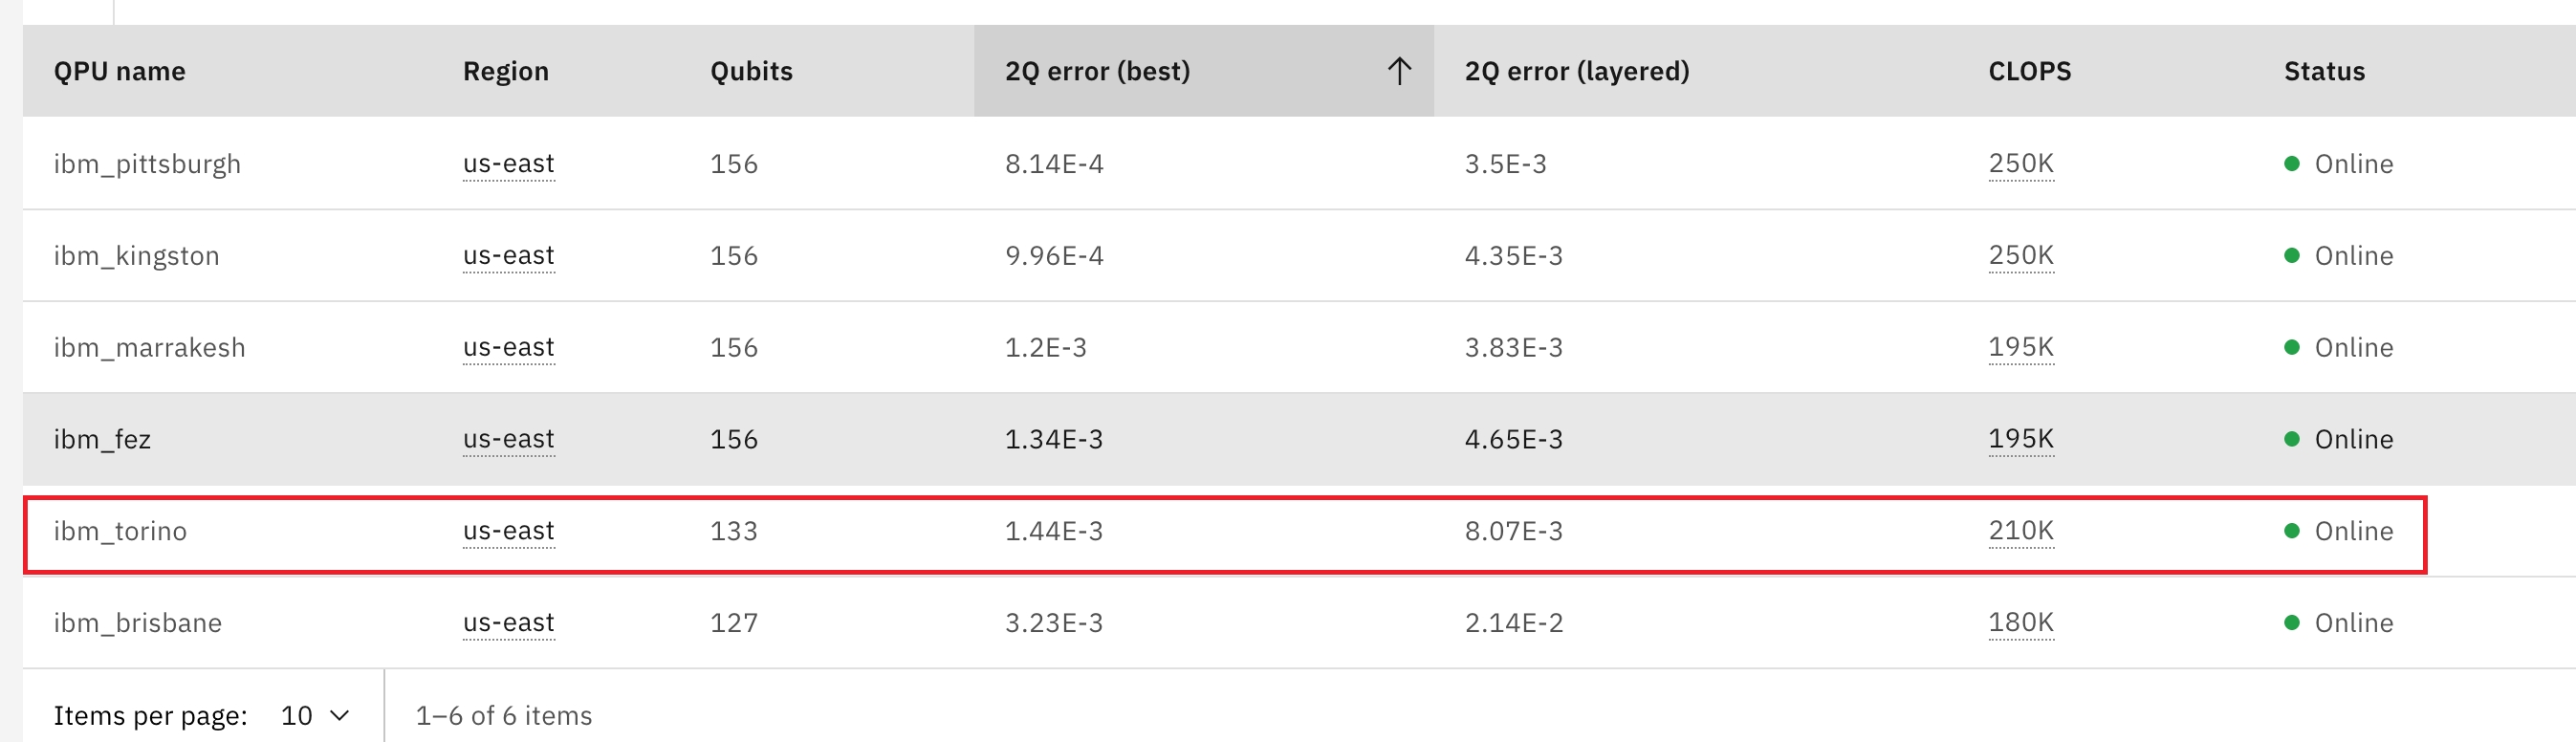

In [ ]:
service = QiskitRuntimeService() # TODO: 这里需要设置API Token

torino_cx = service.backend("ibm_torino", use_fractional_gates=False)
torino_zzphase = service.backend("ibm_torino", use_fractional_gates=True)

pm_zzphase_isa = generate_preset_pass_manager(optimization_level=2, backend=torino_zzphase, scheduling_method="alap")
pm_cx_isa = generate_preset_pass_manager(optimization_level=2, backend=torino_cx, scheduling_method="alap")

In [ ]:
# 运行在真机之前最最后阶段的 transpilation
qft_qiskit_cx = pm_cx_isa.run(qft_qiskit_cx)
qft_canopus_cx = pm_cx_isa.run(qft_canopus_cx)
qft_canopus_zzphase = pm_zzphase_isa.run(qft_canopus_zzphase)

In [ ]:
# TODO: ... 然后提交job然后get counts
from qiskit_ibm_runtime import SamplerV2 as Sampler

def submit_job(qc: QuantumCircuit, backend, shots):
    sampler = Sampler(backend)
    job = sampler.run([qc], shots=shots)
    return job


def get_noisy_counts_from_job(job):
    # job = service.job(jobid)
    job_result = job.result()
    counts = job_result[0].data.meas.get_counts()
    return counts


job_qft_qiskit_cx = submit_job(qft_qiskit_cx, torino_cx, SHOTS)
job_qft_canopus_cx = submit_job(qft_canopus_cx, torino_cx, SHOTS)
job_qft_canopus_zzphase = submit_job(qft_canopus_zzphase, torino_zzphase, SHOTS)


In [ ]:
ideal_counts = get_ideal_counts(qft_qiskit_cx, SHOTS)
ideal_counts

{'000000': 8192}

In [ ]:
qiskit_cx_counts = get_noisy_counts_from_job(job_qft_qiskit_cx)
canopus_cx_counts = get_noisy_counts_from_job(job_qft_canopus_cx)
canopus_zzphase_counts = get_noisy_counts_from_job(job_qft_canopus_zzphase)

In [ ]:
print('Fidelity (Qiskit CX):', qi.hellinger_fidelity(ideal_counts, qiskit_cx_counts))
print('Fidelity (Canopus CX):', qi.hellinger_fidelity(ideal_counts, canopus_cx_counts))
print('Fidelity (Canopus ZZPhase):', qi.hellinger_fidelity(ideal_counts, canopus_zzphase_counts))